## Ramachandran Plot for compounds from PDB base

### PDB file format

**ATOM** records:

describe the coordinates of the atoms 
that are part of the protein

**PDB format** for "ATOM" records (fields used in the code): 

|COLUMNS|DATA TYPE|CONTENTS|
|---|---|---|
|1 -  6|Record name|"ATOM  "|
|13 - 16|Atom|Atom name.|
|23 - 26|Integer|Residue sequence number.|
|31 - 38|Real(8.3)|Orthogonal coordinates for X in Angstroms.|
|39 - 46|Real(8.3)|Orthogonal coordinates for Y in Angstroms.|
|47 - 54|Real(8.3)|Orthogonal coordinates for Z in Angstroms.|

### Angles computation

![img](https://sun9-69.userapi.com/c855332/v855332820/21c9ad/XT_lpZgEWPY.jpg)

$\phi$: $A$ - C, $B$ - N, $C$ - Ca, $D$ - C

$\psi$: $A$ - N, $B$ - Ca, $C$ - C, $D$ - N

In [1]:
import os
import numpy as np

In [2]:
class Ramachandran_Plot:
    '''Class for getting phi and psi angles for Ramachandran Plot
    
    Attributes:
        filename (str): name of .pdb file
        atoms (list of str): list of "ATOM" records from pdb file
        CAs (dict int: (float, float, float)): dictionary `number of 
                                               residue sequence: coordinates of Ca atoms`
        Cs (dict int: (float, float, float)): dictionary `number of 
                                               residue sequence: coordinates of C atoms`
        Ns (dict int: (float, float, float)): dictionary `number of 
                                               residue sequence: coordinates of N atoms`
        Phis (list of float): list of Phi angles
        Psis (list of float): list of Psi angles
    '''
    
    def __init__(self, filename):
        '''
        Args:
            filename (str): name of .pdb file.
        '''
        self.filename = filename
        self.atoms = []
        
        self.CAs = []
        self.Cs = []
        self.Ns = []
        
        self.Phis = []
        self.Psis = []

    def read_file(self):
        '''Function to read pdb file and extract info about Ca, C and N atoms'''
        with open(self.filename, 'r') as f:
            data = f.read().split('\n')
            
        # get from pdb-file only "ATOM" records 
        self.atoms=[line for line in data if (line.startswith('ATOM'))]
        
        # Obtain coordinates and number of residue sequence 
        # for C, N and Ca atoms
        self.CAs = dict([(int(atom[22:26]), \
                          list(map(lambda x: float(x), [atom[30:38], atom[38:46], atom[46:54]]))) \
                         for atom in self.atoms if atom[12:16].strip()=='CA'])  
        self.Cs = dict([(int(atom[22:26]), \
                         list(map(lambda x: float(x), [atom[30:38], atom[38:46], atom[46:54]]))) \
                        for atom in self.atoms if atom[12:16].strip()=='C'])
        self.Ns = dict([(int(atom[22:26]), \
                         list(map(lambda x: float(x), [atom[30:38], atom[38:46], atom[46:54]]))) \
                        for atom in self.atoms if atom[12:16].strip()=='N'])         
    
    def calculate_Phi_Psi(self, method='coord'):
        '''Function to calcualate Phi and Psi angles of the compound
        
        Args:
            method (str): method of angle calculation. `coord` - with coordinate 
                          transformation, `angle` - with angle between planes
        '''
        if method=='coord':
            self.Phis = [self.Torsion_Angles_coord_tranf(self.Cs[res_num-1], \
                                          self.Ns[res_num], \
                                          self.CAs[res_num], \
                                          self.Cs[res_num]) \
                                      for res_num in self.CAs.keys() \
                                      if res_num in self.Cs.keys() and res_num in self.Ns.keys() \
                                      and res_num-1 in self.Cs.keys()]
            self.Psis = [self.Torsion_Angles_coord_tranf(self.Ns[res_num], \
                                          self.CAs[res_num], \
                                          self.Cs[res_num], \
                                          self.Ns[res_num+1]) \
                                      for res_num in self.CAs.keys() \
                                      if res_num in self.Cs.keys() and res_num in self.Ns.keys() \
                                      and res_num+1 in self.Ns.keys()]    
        if method=='angle':
            self.Phis = [self.Torsion_Angles_plane_angles(self.Cs[res_num-1], \
                                          self.Ns[res_num], \
                                          self.CAs[res_num], \
                                          self.Cs[res_num]) \
                                      for res_num in self.CAs.keys() \
                                      if res_num in self.Cs.keys() and res_num in self.Ns.keys() \
                                      and res_num-1 in self.Cs.keys()]
            self.Psis = [self.Torsion_Angles_plane_angles(self.Ns[res_num], \
                                          self.CAs[res_num], \
                                          self.Cs[res_num], \
                                          self.Ns[res_num+1]) \
                                      for res_num in self.CAs.keys() \
                                      if res_num in self.Cs.keys() and res_num in self.Ns.keys() \
                                      and res_num+1 in self.Ns.keys()]
        
    def Torsion_Angles_coord_tranf(self, A, B, C, D):
        '''Function to calculate angle from ABCD geometry with coordinate transformation
        
        Args:
            A (list of floats): x,y,z coordinates of the point
            B (list of floats): x,y,z coordinates of the point
            C (list of floats): x,y,z coordinates of the point
            D (list of floats): x,y,z coordinates of the point
            
        Returns:
            Angle in degrees
        '''
        import numpy as np
        
        A=np.array(A)
        B=np.array(B)
        C=np.array(C)
        D=np.array(D)
        
        # moving points so that B is located
        # in (0,0,0) point
        A-=B
        C-=B
        D-=B
        B-=B

        # perform rotations to place BC along x-axis
        
        # rotation in xy plane (z coordinate remains unchanged)
        # -> C_y = 0
        xy_angle=2*np.pi-np.arctan2(C[1],C[0])
        c, s = np.cos(xy_angle), np.sin(xy_angle)
        R_xy = np.array(((c, -s), (s, c)))
        C[0], C[1] = R_xy@np.array([C[0],C[1]])
        A[0], A[1] = R_xy@np.array([A[0],A[1]])
        D[0], D[1] = R_xy@np.array([D[0],D[1]])
        
        # rotation in xz plane (y coordinate remains unchanged)
        # -> C_z = 0
        xz_angle=2*np.pi-np.arctan2(C[2], C[0])
        c, s = np.cos(xz_angle), np.sin(xz_angle)
        R_xz = np.array(((c, -s), (s, c)))
        C[0], C[2] = R_xz@np.array([C[0],C[2]])
        A[0], A[2] = R_xz@np.array([A[0],A[2]])
        D[0], D[2] = R_xz@np.array([D[0],D[2]])
        
        # perform rotation to place AB in the xy plane
        
        # rotation in zy plane (x coordinate remains unchanged)
        # -> A_z = 0
        yz_angle=2*np.pi-np.arctan2(A[2], A[1])
        c, s = np.cos(yz_angle), np.sin(yz_angle)
        R_yz = np.array(((c, -s), (s, c)))
        A[1], A[2] = R_yz@np.array([A[1],A[2]])
        D[1], D[2] = R_yz@np.array([D[1],D[2]])
        
        # for getting angle value we need to find 
        # angle between vector (D_y, D_z) and y-axis
        
        return(np.angle(np.complex(D[1], D[2]),deg=True))
    
    def Torsion_Angles_plane_angles(self, A, B, C, D):
        '''Function to calculate angle from ABCD geometry with angle between planes
        
        Args:
            A (list of floats): x,y,z coordinates of the point
            B (list of floats): x,y,z coordinates of the point
            C (list of floats): x,y,z coordinates of the point
            D (list of floats): x,y,z coordinates of the point
            
        Returns:
            Angle in degrees
        '''
        import numpy as np
        
        A=np.array(A)
        B=np.array(B)
        C=np.array(C)
        D=np.array(D)
        # Torsion Angle can be interpreted as 
        # an angle between ABC and DCB planes
        # that is angle between their normal vectors
        
        # determine vectors lying in each plane
        plane1_vec1 = A-B
        plane1_vec2 = B-C
        
        plane2_vec1 = D-C
        plane2_vec2 = B-C
        
        # find normal vectors to each plane
        n_ABC = np.cross(plane1_vec1, plane1_vec2)
        n_DCB = np.cross(plane2_vec1, plane2_vec2)
        
        # cos of the angle can be find from scalar product
        # of normal vectors
        cos_angle = np.dot(n_ABC, n_DCB)/np.sqrt(np.dot(n_ABC, n_ABC)*np.dot(n_DCB, n_DCB))

        # sin of the angle can be found as cos of another angle
        # between n_ABC and vector from BCD plane perpendicular to n_BCD
        # and to BC
        
        perp_vec = np.cross(plane1_vec2, n_DCB)
        sin_angle = np.dot(n_ABC, perp_vec)/np.sqrt(np.dot(n_ABC, n_ABC)*np.dot(perp_vec, perp_vec))

        return np.arctan2(sin_angle, cos_angle)/np.pi*180
    
    def plot_graph(self, method='coord', title=''):
        '''Function to plot Ramachandran Plot
        
        
        Args:
            method (str): method of angle calculation. `coord` - with coordinate 
                          transformation, `angle` - with angle between planes
        
        '''
        import matplotlib.pyplot as plt
        import numpy as np
        
        self.read_file()
        self.calculate_Phi_Psi(method=method)
        
        fig, ax = plt.subplots(figsize=(10,6))
        colors = np.random.rand(len(self.Phis))
        ax.set_xlim([-180, 180])
        ax.set_ylim([-180, 180])
        ax.set_xlabel('phi', fontsize=25)
        ax.set_ylabel('psi', fontsize=25)
        ax.grid()
        ax.scatter(self.Phis, self.Psis, c=colors,alpha=0.5)
        ax.set_title(title, fontsize=25)
        
        plt.show()

## Plot


### Compounds:

* [6R06](https://www.rcsb.org/structure/6R06)

* [6TQF](https://www.rcsb.org/structure/6TQF)

* [6R15](https://www.rcsb.org/structure/6R15)

In [3]:
filenames = ['6r06.pdb', '6r15.pdb', '6tqf.pdb']

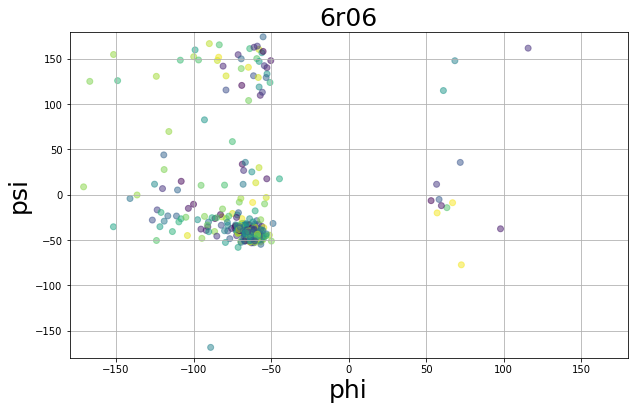

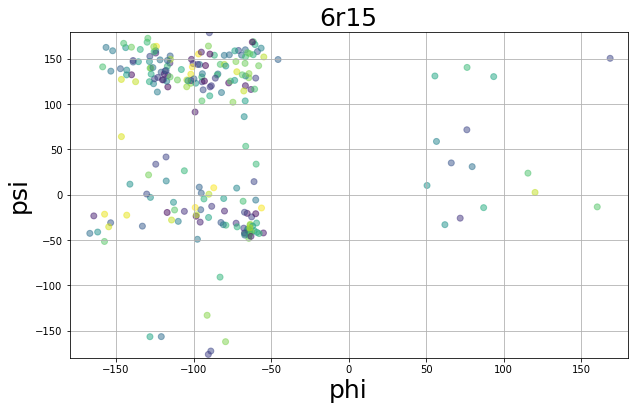

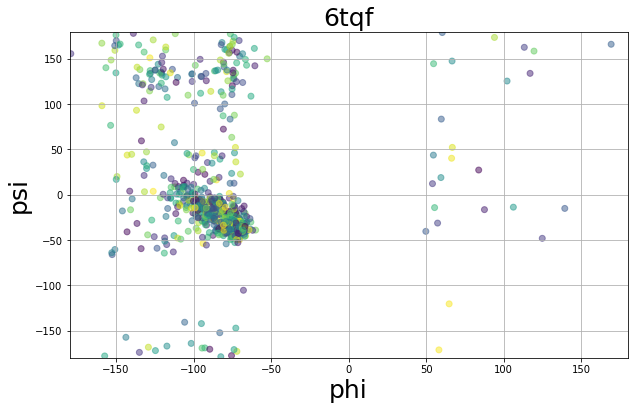

In [4]:
for filename in filenames:
    sample = Ramachandran_Plot(os.path.join('data',filename))
    sample.plot_graph(method = 'coord', title = filename.split('.')[0])                     

## Bonus

Comparison of speed of computations of angles with coordinate transformations vs. with angle between planes

In [5]:
sample_6r06 = Ramachandran_Plot(os.path.join('data', '6r06.pdb'))
sample_6r06.read_file()

In [6]:
%timeit sample_6r06.calculate_Phi_Psi('coord')

52.6 ms ± 4.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%timeit sample_6r06.calculate_Phi_Psi('angle')

80.3 ms ± 3.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Conclusion

Usage of coordinate transformation is 1.5 times faster

## Exam correctness of the plot

Using `pytraj` library. Based on [tutorial](https://amber-md.github.io/pytraj/latest/tutorials/plot_phipsi_trpcage.html)


In [8]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# do some configs to get better plot
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

import numpy as np
import pytraj as pt

In [9]:
def pytraj_Ramachandran_Plot(filename, title = ''):
    traj = pt.load(filename)
    indices = [idx for idx, res in enumerate(traj.top.residues)]
    dataset = pt.multidihedral(traj, 'phi psi', resrange=indices)

    # take data for 'phi' and flatten to 1D array
    phi = np.array([d.values for d in dataset if 'phi' in d.key]).flatten()

    # take data for 'psi' and flatten to 1D array
    psi = np.array([d.values for d in dataset if 'psi' in d.key]).flatten()

    # setup color
    colors = np.random.rand(len(psi))

    fig, ax = plt.subplots(figsize=(10,6))
    colors = np.random.rand(len(psi))
    ax.set_xlim([-180, 180])
    ax.set_ylim([-180, 180])
    ax.set_xlabel('phi', fontsize=25)
    ax.set_ylabel('psi', fontsize=25)
    ax.grid()
    ax.scatter(phi, psi, c=colors,alpha=0.5)
    ax.set_title(title, fontsize=25)
    
    plt.show()

In [10]:
filenames = ['6r06.pdb', '6r15.pdb', '6tqf.pdb']

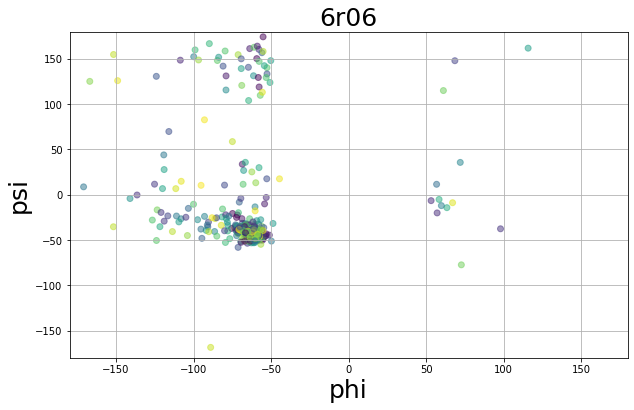

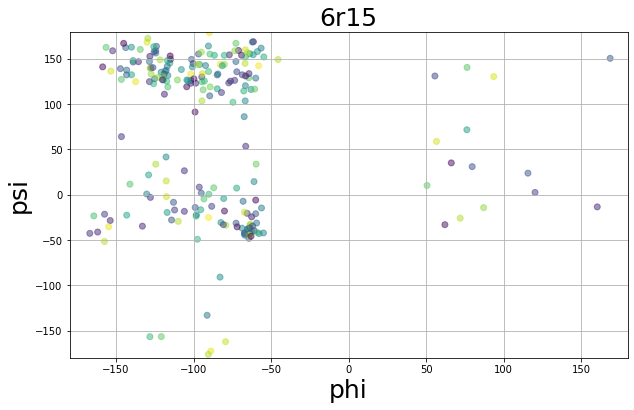

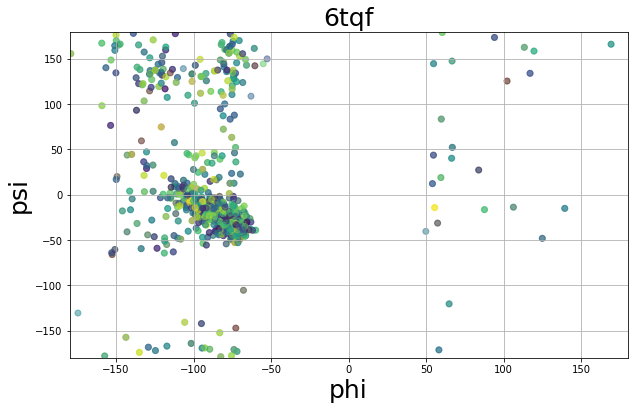

In [11]:
for filename in filenames:
    pytraj_Ramachandran_Plot(os.path.join('data',filename), filename.split('.')[0]) 